# Preparing the corpus

In [76]:
# hide jupyter warning
import warnings
warnings.filterwarnings('ignore')

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [78]:
import pyLDAvis
import pyLDAvis.gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

In [79]:
df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)

In [80]:
# remove duplicates 
# 840 tweets had been droped

df = df[df['lang'] == 'fr']
df = df.sort_values("content") 
  
# dropping ALL duplicte values 
df = df.drop_duplicates(subset ="content", keep = 'first')

In [81]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = df['content']

with open('../input/keywords.txt', encoding='utf-8') as f:
    keywords = f.read().splitlines()

data = data[data.str.contains('|'.join(keywords), case=False)]

# supprimer les tweets inutiles (publicité, concours ..)

with open('../input/ads_words.txt', encoding='utf-8') as f:
    ads_words = f.read().splitlines()

data = data[~data.str.contains('|'.join(ads_words), case=False)]

In [51]:
with open('../input/keywords.txt', encoding='utf-8') as f:
    keywords = f.read().splitlines()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
import re
import json
from html.parser import HTMLParser
from io import StringIO

import demoji
demoji.download_codes()

... OK (Got response in 0.36 seconds)
Writing emoji data to /home/azureuser/.demoji/codes.json ...
... OK


In [83]:
class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.text = StringIO()
        def handle_data(self, d):
            self.text.write(d)
        def get_data(self):
            return self.text.getvalue()
        
def html_free_text(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def emoji_free_text(text):
    return demoji.replace(text, '').strip()

def url_free_text(text):
    text = re.sub(r'(?:\@|https?\://)\S+', '', text)
    return text
    
with open('../input/abrivot_fr.json', encoding='utf-8') as f:
        abrivot = json.load(f)   
        
def abrivot_free_text(text):
    words = text.lower().split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

def punct_free_text(text):
    text_out = simple_preprocess(text, deacc=True, min_len=3)
    #return ' '.join(text_out)
    return text_out

## Pre-Process the data

In [84]:
%%time

data_free_html = data.apply(html_free_text)
data_free_emoji = data_free_html.apply(emoji_free_text)
data_free_url = data_free_emoji.apply(url_free_text)
data_free_abrivot = data_free_url.apply(abrivot_free_text)
data_free_punct = data_free_url.apply(punct_free_text)

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


In [85]:
# Build the bigram and trigrams

data = list(data_free_punct)

bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [86]:
# define a preprocessing function

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# get stopwords
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words = nlp.Defaults.stop_words.union(fr_stopwords)


# final preprocesser
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    #texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    texts = [[word for word in doc if word not in stop_words] for doc in texts]

    
    # bi-gram and tri-gram implementation
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [87]:
%%time

data_ready = process_words(data)

CPU times: user 51.8 s, sys: 0 ns, total: 51.8 s
Wall time: 51.8 s


In [88]:
# create the Dictionary

id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 5283


In [89]:
# create the corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [90]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

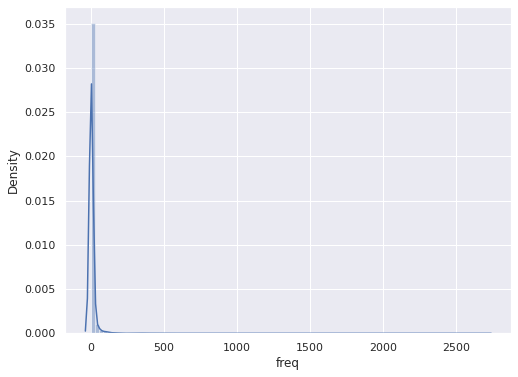

In [91]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [92]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
max,2700
iphone,1719
pro,1651
prix,1580
chargeur,1562
apple,1458
photo,1235
batterie,1023
mini,936
euro,431


In [93]:
# remove the 3 top words
threshold = dict_df.sort_values('freq', ascending=False).iloc[9].values[0]
extension = dict_df[dict_df.freq>threshold].index.tolist()

extension = [word for word in extension if word not in keywords]

In [53]:
extension

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['apple', 'max', 'iphone', 'pro', 'mini']

In [107]:
stop_words

{'a',
 'abord',
 'absolument',
 'afin',
 'ah',
 'ai',
 'aie',
 'ailleurs',
 'ainsi',
 'ait',
 'allaient',
 'allo',
 'allons',
 'allô',
 'alors',
 'anterieur',
 'anterieure',
 'anterieures',
 'appl',
 'apple',
 'apres',
 'après',
 'as',
 'assez',
 'attendu',
 'au',
 'aucun',
 'aucune',
 'aucuns',
 'aujourd',
 "aujourd'hui",
 'aupres',
 'auquel',
 'aura',
 'auraient',
 'aurait',
 'auront',
 'aussi',
 'autre',
 'autrefois',
 'autrement',
 'autres',
 'autrui',
 'aux',
 'auxquelles',
 'auxquels',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avoir',
 'avons',
 'ayant',
 'bah',
 'bas',
 'basee',
 'bat',
 'beau',
 'beaucoup',
 'bien',
 'bigre',
 'bon',
 'bonjour',
 'bonsoir',
 'boum',
 'bravo',
 'brrr',
 "c'",
 'ca',
 'car',
 'ce',
 'ceci',
 'cela',
 'celle',
 'celle-ci',
 'celle-là',
 'celles',
 'celles-ci',
 'celles-là',
 'celui',
 'celui-ci',
 'celui-là',
 'cent',
 'cependant',
 'certain',
 'certaine',
 'certaines',
 'certains',
 'certes',
 'ces',
 'cet',
 'cette',
 'ceux',
 'ceux-c

In [94]:
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
# tweek the extension list to get words with typo
extension.append('appl')
extension.append('iphon')

In [95]:
# add high frequency words to stop words list
stop_words.update(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 5085


In [96]:
# Filter extreme words
# Filter out words that occur less than 20 documents, or more than
# 90% of the documents.

id2word.filter_extremes(no_below=20, no_above=0.9)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 354


In [97]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Finding the optimal number of topics

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaMulticore, CoherenceModel
from gensim import corpora

In [99]:
%%time

# Considering 10-70 topics, as the last is cut off
num_topics = list(range(5, 50, 1)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=i,
                                chunksize=2000,
                                passes=25,
                                iterations=70,
                                decay=0.5,
                                random_state=100
                                #per_word_topics=True,
                                #minimum_phi_value=0.02,
                                #minimum_probability=0.4,
                                #eval_every=1
                                )

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

CPU times: user 20min 38s, sys: 28.8 s, total: 21min 7s
Wall time: 20min 55s


In [100]:
# Now create a function to derive the Jaccard similarity of two topics:

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [101]:
# Use the above to derive the mean stability across topics by considering the next topic:

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [102]:
# calculate the coherence value with the built in gensim

coherences = [CoherenceModel(model=LDA_models[i], texts=data_ready, dictionary=id2word, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [103]:
# From here derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics:

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

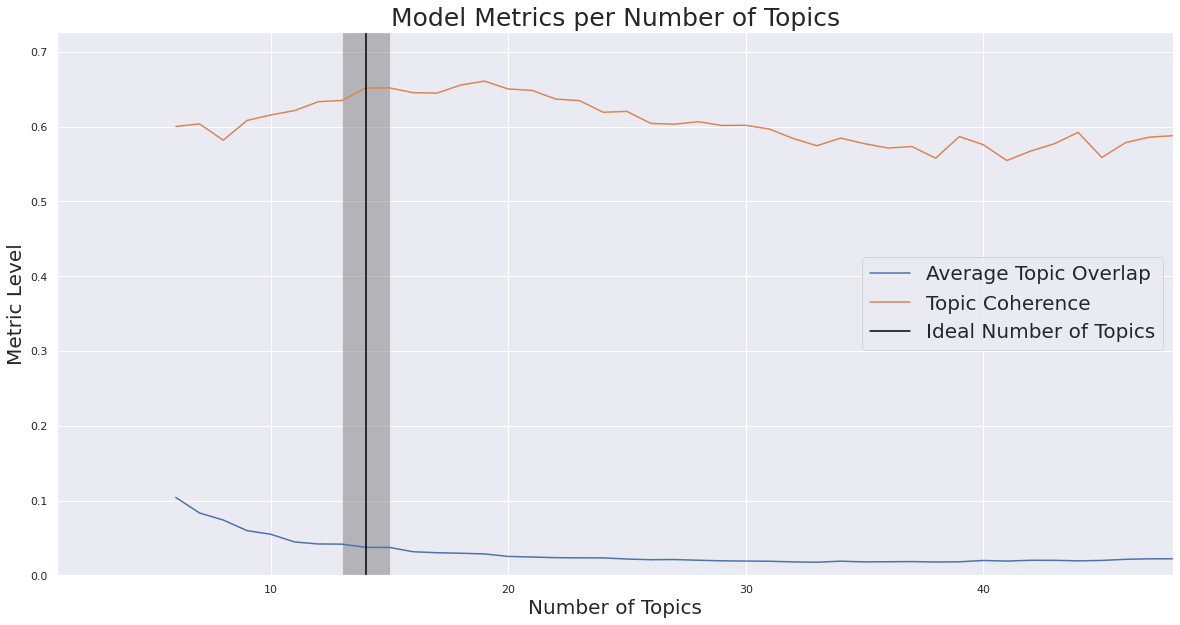

In [104]:
# Finally graph these metrics across the topic numbers:

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

Your ideal number of topics will maximize coherence and minimize the topic overlap based on Jaccard similarity.

In [105]:
print('Ideal number of topics: ', ideal_topic_num)

Ideal number of topics:  14


# Building the LDA Model

Download the LDA mallet from `!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip`  
Extract the model `!unzip mallet-2.0.8.zip`

In [31]:
# mallet_path = '../packages/mallet-2.0.8/bin/mallet'
# ldamallet = gensim.models.wrappers.LdaMallet(
#     mallet_path,
#     corpus=corpus,
#     num_topics=ideal_topic_num,
#     id2word=id2word,
#     alpha=.1)
# #(mallet_path, corpus=corpus, num_topics=28, id2word=id2word, topic_threshold=0.5)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
ldamallet = LDA_models[ideal_topic_num]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.6221516955624309


In [34]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1,
  [('chargeur', 0.27158585),
   ('charge', 0.118053146),
   ('ecouteur', 0.044963274),
   ('lieu', 0.039543856),
   ('gars', 0.035833757),
   ('choisir', 0.03184469),
   ('magsafe', 0.031320963),
   ('serie', 0.030890372),
   ('hesite', 0.025198933),
   ('commence', 0.024910478)]),
 (6,
  [('max', 0.9045445),
   ('heure', 0.033114363),
   ('modele', 0.015208319),
   ('grace', 0.011273102),
   ('defaut', 0.009849057),
   ('predecesseur', 0.007655753),
   ('place', 0.005582768),
   ('scelle', 0.003777654),
   ('bloc', 0.002651954),
   ('avance', 1.8839444e-05)]),
 (9,
  [('niveau', 0.12931551),
   ('part', 0.10802211),
   ('face', 0.0923299),
   ('soir', 0.09144673),
   ('cadeau', 0.07149633),
   ('gnt', 0.06420333),
   ('matin', 0.055312812),
   ('peine', 0.04287857),
   ('penurie', 0.042386696),
   ('casse', 0.03992217)]),
 (8,
  [('recu', 0.09409015),
   ('technologie', 0.078074746),
   ('capteur', 0.06882543),
   ('tech', 0.06420416),
   ('probleme', 0.04962276),
   ('performanc

In [35]:
# save the model for later

import pickle
pickle.dump(ldamallet, open("../saved models/ldamodel.pkl", "wb"))

# load the model
#ldamallet = pickle.load(open("../saved models/ldamallet.pkl", "rb"))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# distribution of topics for each document

tm_results = ldamallet[corpus]

# We can get the most dominant topic of each document as below:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# get most probable words for the given topicis

topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# create a dataframe for term-topic matrix:

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics],
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
Term1,samsung,chargeur,prix,apple,iphone,pro,max,question,recu,niveau,batterie,ecran,telephone,protection,taille,mini,euro,keynote,photo
Term2,compte,charge,difference,couleur,mise,smartphone,heure,version,technologie,part,pouce,oled,devoile,test_bluetooth,mini,autonomie,change,rapport,cote
Term3,besoin,ecouteur,lien,magsafe,homepod,test,modele,vie,capteur,face,coque,vien,apple,marche,video,appareil,client,cas,prise
Term4,meilleur,lieu,reseau,igeneration,recharge,test_bluetooth,grace,promo,tech,soir,temps,livre,offre,argent,demande,sortie,moment,film,boite
Term5,qualite,gars,lance,fin,utilisation,vente,defaut,reduction,probleme,cadeau,internet,succe,site,voiture,achete,reparation,prefere,produit,suite


In [39]:
# another option

# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Terms per Topic
Topic1,"samsung, compte, besoin, meilleur, qualite, super, attention, plaisir, information, mec, cherche, jeu, decembre, processeur, experience, resultat, gratuit, filme, induction, completement"
Topic2,"chargeur, charge, ecouteur, lieu, gars, choisir, magsafe, serie, hesite, commence, perso, fil, livraison, carte, comprend, orange, comparaison, gosse, vend, vitesse"
Topic3,"prix, difference, lien, reseau, lance, article, choix, regarde, novembre, baisse, bug, homme, bord, presse_citron, vendeur, iphone, experience, rapport, dinguerie, internet"
Topic4,"apple, couleur, magsafe, igeneration, fin, generation, iphon, application, connexion, ami, gagnez, app, vente, compatible, pays, annonce, store, lance, dolby_vision, modele"
Topic5,"iphone, mise, homepod, recharge, utilisation, bientot, annonce, carte_sim, pote, rouge, capture, jsp, chaud, heure, avance, mini, avis, pro, produit, gamme"
Topic6,"pro, smartphone, test, test_bluetooth, vente, avis, stockage, image, youtube, dxomark, fonction, rumeur, equipe, note, hello, capacite, encoche, octobre, belgium, monde"
Topic7,"max, heure, modele, grace, defaut, predecesseur, place, scelle, bloc, avance, mini, iphone, message, pro, capteur, batterie, achete, test, test_bluetooth, option"
Topic8,"question, version, vie, promo, reduction, operateur, cuir, etui_protection, iphonote, ipad, production, main, tombe, mort, remise, ligne, code, profite, prevu, dossier"
Topic9,"recu, technologie, capteur, tech, probleme, performance, fonds, chute, femme, cause, fille, terme, annee, baisse, vena, innovation, silicone, pose, position, facon"
Topic10,"niveau, part, face, soir, cadeau, gnt, matin, peine, penurie, casse, vendre, parent, clavier, veut, explose, condition, bouton, force, rhinoshield, promotion"


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


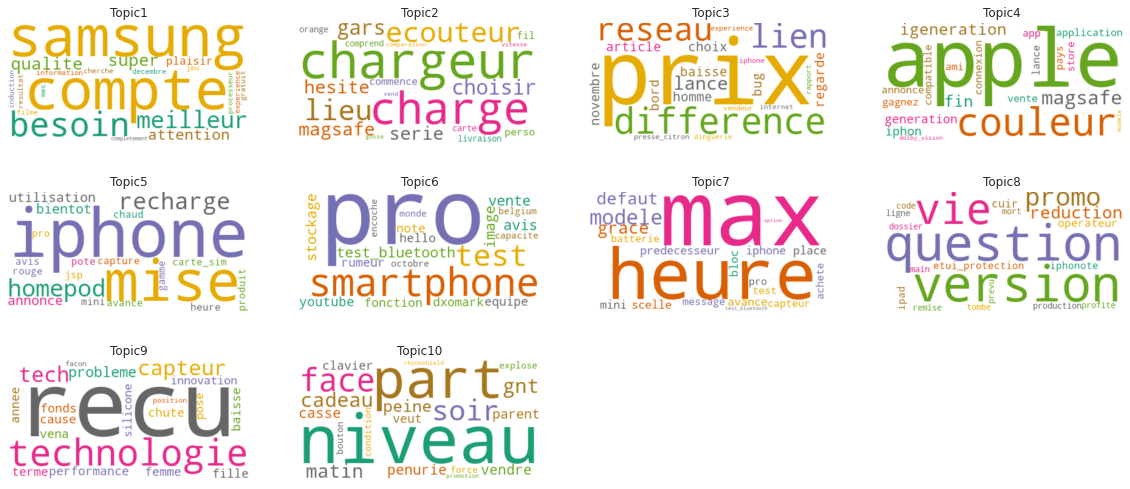

In [40]:
# worldcloud

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [41]:
# visiualize with pyLDAvis
# the mallet model must be converted to a gensim lda model

# from gensim.models.ldamodel import LdaModel

# def convertldaMalletToldaGen(mallet_model):
#     model_gensim = LdaModel(
#         id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
#         alpha=mallet_model.alpha) 
#     model_gensim.state.sstats[...] = mallet_model.wordtopics
#     model_gensim.sync_state()
#     return model_gensim

# ldagensim = convertldaMalletToldaGen(ldamallet)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# import pyLDAvis.gensim as gensimvis

# vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
# pyLDAvis.display(vis_data)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamallet, corpus, id2word)
vis

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.146477 -0.087028  1       1        7.857589
6      0.048320  0.077232  2       1        7.722784
4      0.041953  0.047577  3       1        6.726699
3      0.217290 -0.290450  4       1        6.490239
2      0.051067  0.076804  5       1        6.280723
15    -0.258707 -0.101954  6       1        6.024985
1      0.078025 -0.031562  7       1        5.766834
18     0.043219  0.136158  8       1        5.336886
14    -0.327359 -0.130125  9       1        5.301747
10     0.035354  0.132609  10      1        5.073447
12     0.194176 -0.283005  11      1        4.911060
13    -0.148071 -0.036975  12      1        4.657141
8      0.039807  0.093428  13      1        4.225430
16     0.013375  0.013191  14      1        4.087320
17     0.025543  0.046684  15      1        4.074903
0      0.029290  0.107930  16      1        3.936365
11     0.018694  0.085848  17      1        3.931827
7      0.031060  0.075104  18      1        3.836935
9      0.013444  0.068534  19      1        3.757088, topic_info=            Term         Freq        Total Category  logprob  loglift
2    max          2389.000000  2389.000000  Default  30.0000  30.0000
11   prix         1447.000000  1447.000000  Default  29.0000  29.0000
22   iphone       1479.000000  1479.000000  Default  28.0000  28.0000
23   pro          1467.000000  1467.000000  Default  27.0000  27.0000
33   photo        1173.000000  1173.000000  Default  26.0000  26.0000
..     ...                ...          ...      ...      ...      ...
127  heure        0.063087     103.942316   Topic19 -9.9214  -4.1256 
28   mini         0.063082     905.341839   Topic19 -9.9215  -6.2901 
271  imagine      0.063026     25.665489    Topic19 -9.9223  -2.7278 
252  airpod       0.063015     57.174758    Topic19 -9.9225  -3.5290 
204  utilisation  0.063005     72.090888    Topic19 -9.9227  -3.7609 

[746 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
340   14     0.807172  absence
340   16     0.161434  absence
291   6      0.966027  accord 
3     14     0.946117  achat  
219   9      0.993240  achete 
...   ..          ...    ...  
208   12     0.916939  voiture
203   17     0.986065  vue    
339   14     0.964548  xiaomi 
107   1      0.862010  youtube
107   14     0.125383  youtube

[442 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 5, 4, 3, 16, 2, 19, 15, 11, 13, 14, 9, 17, 18, 1, 12, 8, 10])

# Dominant Topics for Each Document


In [44]:
# create a dataframe
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Tweet_id'] = data_free_abrivot.index
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,19381,7,26.32,"max, heure, modele, grace, defaut, predecesseur, place, scelle, bloc, avance, mini, iphone, message, pro, capteur, batterie, achete, test, test_bluetooth, option"
1,6029,13,41.05,"telephone, devoile, apple, offre, site, plan, voi, plutot, octobre, precommande, dommage, bonplan, dollar, dispo, moche, piece, graphite, possession, blague, mail"
2,53240,15,52.63,"taille, mini, video, demande, achete, protection, mode, envie, point, coque_etui, puissance, objectif, spigen, pro, presentation, test, composant, oeil, nom, chance"
3,11631,17,17.56,"euro, change, client, moment, prefere, coute, janvier, affaire, famille, poids, xiaomi, occasion, bleu, macgeneration, solde, absence, soeur, puce, argument, achat"
4,2833,11,52.63,"batterie, pouce, coque, temps, internet, travail, place, dinguerie, jailbreak, message, photographie, ville, date, souci, vendeur, garde, haut_parleur, amelioration, rhinoshield, mini"


We can use pandas groupby function on “Dominant Topic” column and get the document counts for each topic and its percentage in the corpus with chaining agg function.

In [45]:
# Documents distribution ovec topics

dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,3132,17.22
1,2,714,3.93
2,3,1363,7.50
3,4,1205,6.63
4,5,1314,7.23
5,6,1168,6.42
6,7,1987,10.93
7,8,432,2.38
8,9,391,2.15
9,10,400,2.20


In [46]:
# the most dominant document per topic

corpus_topic_df.groupby('Dominant Topic').\
    apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,63883,1,76.32,"samsung, compte, besoin, meilleur, qualite, super, attention, plaisir, information, mec, cherche, jeu, decembre, processeur, experience, resultat, gratuit, filme, induction, completement"
1,22934,2,84.21,"chargeur, charge, ecouteur, lieu, gars, choisir, magsafe, serie, hesite, commence, perso, fil, livraison, carte, comprend, orange, comparaison, gosse, vend, vitesse"
2,58042,3,76.32,"prix, difference, lien, reseau, lance, article, choix, regarde, novembre, baisse, bug, homme, bord, presse_citron, vendeur, iphone, experience, rapport, dinguerie, internet"
3,60112,4,81.05,"apple, couleur, magsafe, igeneration, fin, generation, iphon, application, connexion, ami, gagnez, app, vente, compatible, pays, annonce, store, lance, dolby_vision, modele"
4,47572,5,76.32,"iphone, mise, homepod, recharge, utilisation, bientot, annonce, carte_sim, pote, rouge, capture, jsp, chaud, heure, avance, mini, avis, pro, produit, gamme"
5,43699,6,81.05,"pro, smartphone, test, test_bluetooth, vente, avis, stockage, image, youtube, dxomark, fonction, rumeur, equipe, note, hello, capacite, encoche, octobre, belgium, monde"
6,29272,7,76.32,"max, heure, modele, grace, defaut, predecesseur, place, scelle, bloc, avance, mini, iphone, message, pro, capteur, batterie, achete, test, test_bluetooth, option"
7,25964,8,81.05,"question, version, vie, promo, reduction, operateur, cuir, etui_protection, iphonote, ipad, production, main, tombe, mort, remise, ligne, code, profite, prevu, dossier"
8,29895,9,76.32,"recu, technologie, capteur, tech, probleme, performance, fonds, chute, femme, cause, fille, terme, annee, baisse, vena, innovation, silicone, pose, position, facon"
9,37655,10,68.42,"niveau, part, face, soir, cadeau, gnt, matin, peine, penurie, casse, vendre, parent, clavier, veut, explose, condition, bouton, force, rhinoshield, promotion"


# Hyper parameter tuning

In [128]:
LdaMulticore?

## Minimum Probabilities
`minimum_probability` : Topics with a probability lower than this threshold will be filtered out.

In [119]:
minimum_probabilities = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

LDA_models = {}
for min_proba in minimum_probabilities:
    LDA_models[min_proba] = LdaMulticore(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=ideal_topic_num,
                                    chunksize=2000,
                                    passes=25,
                                    iterations=70,
                                    decay=0.5,
                                    random_state=100,
                                    minimum_probability=min_proba,
                                    eval_every=1
                                    )
        

In [120]:
# calculate the coherence value with the built in gensim

coherences = [CoherenceModel(model=LDA_models[min_proba], texts=data_ready,
                             dictionary=id2word, coherence='c_v').get_coherence() for min_proba in minimum_probabilities]

<AxesSubplot:xlabel='minimum probabilitie', ylabel='coherence score'>

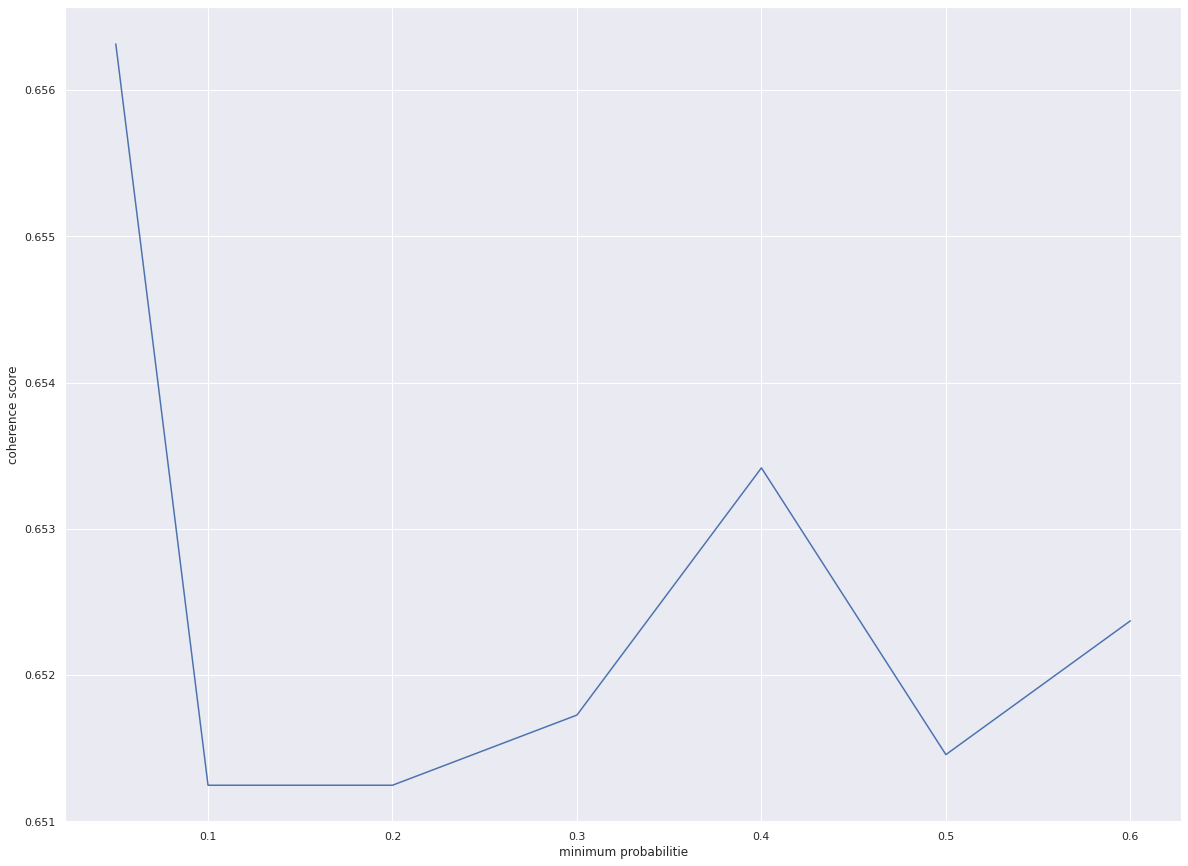

In [121]:
d = {'minimum probabilitie': minimum_probabilities, 'coherence score': coherences}
proba_coherence = pd.DataFrame(d)
sns.lineplot(x='minimum probabilitie', y='coherence score', data=proba_coherence)

In [125]:
ldamodel = LDA_models[0.05]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.023287  0.221594  1       1        11.118326
4     -0.122641 -0.080734  2       1        8.937721 
1     -0.049481  0.159341  3       1        8.373946 
13    -0.116769 -0.222154  4       1        7.397586 
10    -0.111806  0.041964  5       1        7.232621 
5     -0.045763  0.183548  6       1        7.143305 
3      0.302522 -0.066777  7       1        7.041710 
2      0.038477 -0.067396  8       1        6.660681 
12    -0.117257 -0.139774  9       1        6.357050 
0     -0.096161 -0.041549  10      1        6.263786 
9     -0.011332  0.022078  11      1        6.047667 
6      0.163671 -0.182713  12      1        6.027046 
7      0.245543  0.107795  13      1        5.831056 
11    -0.055717  0.064779  14      1        5.567500 , topic_info=             Term         Freq        Total Category  logprob  loglift
9    prix          1333.000000  1333.000000  Default  30.0000  30.0000
24   photo         1160.000000  1160.000000  Default  29.0000  29.0000
4    chargeur      1374.000000  1374.000000  Default  28.0000  28.0000
25   batterie      957.000000   957.000000   Default  27.0000  27.0000
52   protection    487.000000   487.000000   Default  26.0000  26.0000
..          ...           ...          ...       ...      ...      ...
214  support       24.791682    41.143514    Topic14 -4.0956   2.3817 
139  encoche       6.804184     28.866622    Topic14 -5.3886   1.4431 
110  vendre        7.672985     46.385667    Topic14 -5.2684   1.0889 
163  amelioration  3.778306     24.741217    Topic14 -5.9768   1.0090 
154  cote          14.299635    96.191261    Topic14 -4.6459   0.9821 

[493 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
327   1      0.970447  absence
275   14     0.980666  accord 
1     6      0.794479  achat  
1     10     0.198620  achat  
205   7      0.989709  achete 
...   ..          ...    ...  
197   3      0.982466  voiture
191   9      0.972060  vue    
326   1      0.185181  xiaomi 
326   9      0.787020  xiaomi 
100   11     0.987933  youtube

[436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 2, 14, 11, 6, 4, 3, 13, 1, 10, 7, 8, 12])

In [126]:
ldamodel = LDA_models[0.4]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.061380  0.098553  1       1        8.796959
7      0.364895 -0.009336  2       1        8.716884
8      0.354389 -0.021070  3       1        8.377533
1      0.035745 -0.042381  4       1        8.030220
13    -0.098798 -0.114320  5       1        7.553956
10    -0.067898  0.265742  6       1        7.308168
3     -0.074796 -0.153513  7       1        7.072909
5     -0.052968 -0.106492  8       1        7.026147
12    -0.050733 -0.057329  9       1        6.706896
2     -0.066695  0.229392  10      1        6.478235
9     -0.068316  0.098296  11      1        6.258782
0     -0.073277 -0.048602  12      1        6.157329
6     -0.117146 -0.216836  13      1        5.987246
11    -0.023021  0.077896  14      1        5.528737, topic_info=           Term         Freq        Total Category  logprob  loglift
9    prix        1339.000000  1339.000000  Default  30.0000  30.0000
24   photo       1168.000000  1168.000000  Default  29.0000  29.0000
4    chargeur    1407.000000  1407.000000  Default  28.0000  28.0000
25   batterie    959.000000   959.000000   Default  27.0000  27.0000
52   protection  489.000000   489.000000   Default  26.0000  26.0000
..          ...         ...          ...       ...      ...      ...
44   oled        21.733429    142.890343   Topic14 -4.2203   1.0120 
319  con         0.084952     13.516024    Topic14 -9.7648  -2.1743 
347  belgium     0.084952     13.716995    Topic14 -9.7648  -2.1891 
90   novembre    0.084971     71.164833    Topic14 -9.7646  -3.8352 
110  vendre      0.084961     44.957929    Topic14 -9.7647  -3.3761 

[507 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
327   3      0.978844  absence
275   14     0.969638  accord 
1     8      0.791552  achat  
1     12     0.197888  achat  
205   7      0.983483  achete 
...   ..          ...    ...  
94    9      0.972991  vitesse
239   11     0.982430  voi    
197   4      0.992699  voiture
191   9      0.989105  vue    
100   11     0.990887  youtube

[423 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 9, 2, 14, 11, 4, 6, 13, 3, 10, 1, 7, 12])

In [127]:
ldamodel = LDA_models[0.6]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.060120 -0.150585  1       1        8.887535
7      0.362962  0.036166  2       1        8.817571
8      0.350471  0.091240  3       1        8.401705
1      0.023556 -0.107563  4       1        7.945436
13    -0.111035  0.185020  5       1        7.505656
10    -0.047651 -0.227232  6       1        7.262404
3     -0.084104  0.092816  7       1        7.082539
5     -0.057902  0.075574  8       1        7.025627
12    -0.072569  0.114569  9       1        6.699336
2     -0.017329 -0.135840  10      1        6.464504
9     -0.064317 -0.037925  11      1        6.206408
0     -0.072493  0.001863  12      1        6.154655
6     -0.131373  0.220251  13      1        5.981906
11    -0.018096 -0.158355  14      1        5.564718, topic_info=           Term         Freq        Total Category  logprob  loglift
9    prix        1337.000000  1337.000000  Default  30.0000  30.0000
24   photo       1168.000000  1168.000000  Default  29.0000  29.0000
4    chargeur    1401.000000  1401.000000  Default  28.0000  28.0000
25   batterie    961.000000   961.000000   Default  27.0000  27.0000
52   protection  491.000000   491.000000   Default  26.0000  26.0000
..          ...         ...          ...       ...      ...      ...
44   oled        21.260012    140.095813   Topic14 -4.2488   1.0032 
319  con         0.084658     13.469547    Topic14 -9.7747  -2.1808 
347  belgium     0.084658     13.705514    Topic14 -9.7747  -2.1982 
148  besoin      0.084660     108.668486   Topic14 -9.7747  -4.2687 
53   appareil    0.084660     344.863084   Topic14 -9.7747  -5.4235 

[506 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
327   3      0.982719  absence
275   14     0.972920  accord 
1     8      0.791211  achat  
1     12     0.197803  achat  
205   7      0.985188  achete 
...   ..          ...    ...  
94    9      0.978214  vitesse
239   11     0.984027  voi    
197   4      0.988279  voiture
191   9      0.973738  vue    
100   11     0.991020  youtube

[429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 9, 2, 14, 11, 4, 6, 13, 3, 10, 1, 7, 12])

## per_word_topics & minimum_phi_value
`minimum_phi_value` : if `per_word_topics` is True, this represents a lower bound on the term probabilities.

`per_word_topics` : If True, the model also computes a list of topics, sorted in descending order of most likely topics for
    each word, along with their phi values multiplied by the feature length (i.e. word count).